# Méthode du synthetic control pour mesurer l'effet des "incentives" à la vaccination aux États-Unis
## Version simplifiée (synthetic control uniquement)

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# On supprime le New Hampshire à cause d'irrégularités dans ses données vaccinales

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}

In [80]:
df_states = {}
for X in states:
  # fichiers csv à trouver dans le drive partagé
    path = 'state_vax_csv/'+X+'.csv'
    df_states[X] = pd.read_csv(path, sep=',')
    df_states[X] = df_states[X].loc[::-1].reset_index(drop=True)
    df_states[X] = df_states[X].loc[67:,:].reset_index(drop=True)

In [81]:
# On remarque qu'il y a des problèmes dans le report des doses administrées : il arrive que le pourcentage de doses
# administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
# On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
# Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report

tf = len(df_states['CA'])

for seg in ["Administered_Dose1_Pop_Pct", "Administered_Dose1_Recip_12_17_Pct", "Administered_Dose1_Recip_18_64_Pct", "Administered_Dose1_Recip_65PlusPop_Pct"]:
    for state in states:
        for t in range(1,tf):
            if df_states[state].loc[t, seg] < df_states[state].loc[t-1, seg]:
                #on a un souci à partir du temps t
                j = t
                flag = True
                while j < tf and flag:
                    if df_states[state].loc[j, seg] >= df_states[state].loc[t-1, seg]:
                        #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                        a_t = df_states[state].loc[t-1, seg]
                        a_j = df_states[state].loc[j, seg]
                        
                        #on interpole linéairement
                        for i in range(t,j):
                            df_states[state].loc[i, seg] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                        flag = False
                    j +=1 
                        
                if flag:
                    #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                    for i in range(t,tf):
                        df_states[state].loc[i, seg] = df_states[state].loc[t-1, seg]

In [82]:
# On s'intéresse à la colonne du pourcentage de personnes ayant reçu au moins une dose. 
# C'est notre "response variable" que l'on cherche à modéliser après l'intervention.

df_dose1 = {"All":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}
df_admin = {}

for X in states:
    df_dose1["All"][X] = df_states[X].loc[:,'Administered_Dose1_Pop_Pct']
    df_dose1["12-17"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_12_17_Pct']
    df_dose1["18-64"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_18_64_Pct']
    df_dose1["65Plus"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_65PlusPop_Pct']
    df_admin[X] = df_states[X].loc[:,'Admin_Per_100K']

ls_dose1 = {"All":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}
for k in ["All", "12-17", "18-64", "65Plus"]:
    for X in states:
        ls_dose1[k][X] = df_dose1[k][X].to_numpy()

In [83]:
df_prm = pd.read_excel('parameters.xlsx', 'By state code', index_col=0)
df_prm = df_prm.drop(columns=['Population'])
prm = df_prm.to_numpy()
    
state_vector = {}
for i in range(len(states)):
    state_vector[states[i]] = prm[i]

In [84]:
# Normalisation et moyenne à 0

df_prm_scaled = (df_prm-df_prm.mean())/df_prm.std()
prm_scaled = df_prm_scaled.to_numpy()

state_vector_scaled = {}
for i in range(len(states)):
    state_vector_scaled[states[i]] = prm_scaled[i]

In [59]:
incentives = pd.read_csv('incentive_list_updated.csv', index_col=None)

incentives_grp = {}
incentives_grp["18+"] = incentives.loc[(incentives["Condition"] != "12-17") & (incentives["Condition"] != "5-11") & (incentives["Condition"] != "5-18"), :]
incentives_grp["12-17"] = incentives.loc[(incentives["Condition"] != "18+") & (incentives["Condition"] != "5-11") & (incentives["Condition"] != "21+"), :]

target_states_all = {}
target_states_all["18+"] = set(incentives_grp["18+"]["State code"])  
target_states_all["12-17"] = set(incentives_grp["12-17"]["State code"])
    
control_states_all = {}
control_states_all["18+"] = [X for X in states if not (X in target_states_all["18+"])]
control_states_all["12-17"] = [X for X in states if not (X in target_states_all["12-17"])]

control_states_names = {}
control_states_names["18+"] = [states_names[X] for X in control_states_all["18+"]]
control_states_names["12-17"] = [states_names[X] for X in control_states_all["12-17"]]

In [60]:
dates = {"18+":{}, "12-17":{}}
category = {}
for X in target_states_all["18+"]:
    dates["18+"][X] = incentives_grp["18+"].loc[incentives_grp["18+"]["State code"] == X, "Incentive t0"]
    dates["18+"][X] = dates["18+"][X].iloc[0]
for X in target_states_all["12-17"]:
    dates["12-17"][X] = incentives_grp["12-17"].loc[incentives_grp["12-17"]["State code"] == X, "Incentive t0"]
    dates["12-17"][X] = dates["12-17"][X].iloc[0]  

In [61]:
import datetime
inc_t0 = {}
inc_t0["All"] = {}
inc_t0["18-64"] = {}
inc_t0["65Plus"] = {}

for X in target_states_all["18+"]:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates["18+"][X]
  t0_date = datetime.date(int(t0_date_str[6:]), int(t0_date_str[3:5]), int(t0_date_str[:2]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0["All"][X] = t0
  inc_t0["18-64"][X] = t0
  inc_t0["65Plus"][X] = t0

inc_t0["12-17"] = {}

for X in target_states_all["12-17"]:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates["12-17"][X]
  t0_date = datetime.date(int(t0_date_str[6:]), int(t0_date_str[3:5]), int(t0_date_str[:2]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0["12-17"][X] = t0
  if inc_t0["All"][X] > t0:
    inc_t0["All"][X] = t0

In [62]:
def norm(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.dot(pred_diff, pred_diff_v)
    return np.sqrt(res)

L1 = 0.6
L2 = 0.1

def norm_reg(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.sqrt(np.dot(pred_diff, pred_diff_v))
    res += L1*np.linalg.norm(w)
    res += L2*sum(np.abs(w))
    return res

def mspe(y1, y, w):
    interv = np.dot(np.transpose(y), w)
    interv_diff = y1 - interv
    res = np.dot(interv_diff, interv_diff)
    return res

In [63]:
# Définition des fonctions d'optimisation pour le contrôle synthétique

from scipy.optimize import minimize, fmin_slsqp

def constraint(w, v, x, x1):
    return np.sum(w) - 1

def con(v):
    return np.sum(v) - 1
cons = {'type':'eq', 'fun': con}

def mspe_opt_w(v_guess, w_guess, x, x1, y, y1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v_guess, x, x1), disp=False)
    return mspe(y1, y, w_opt)

def opt_v(v_guess, w_guess, x, x1, y, y1):
    v_opt = minimize(mspe_opt_w, v_guess, constraints = cons, bounds=[(0.0, 1.0)]*len(v_guess), 
             args=(w_guess, x, x1, y, y1), method='SLSQP')
    return v_opt.x

def opt_w(w_guess, v, x, x1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v, x, x1), disp=False)
    return w_opt

In [68]:
# Contrôle synthétique

import random

y1_prediction = {}

# dfs={}
# dfs['A'] = pd.DataFrame(columns=control_states['A'])
# dfs['B'] = pd.DataFrame(columns=control_states['B'])
# dfs['C'] = pd.DataFrame(columns=control_states['C'])
# dfs['D'] = pd.DataFrame(columns=control_states['D'])

w_dic = {k:0 for k in target_states_all}

def synthetic(ls_dose1, state_vector_scaled, t_fit, t_test=10, states_choice=target_states_all, classe="Pop", plot=True):

  if classe == "12-17":
    states_choice = target_states_all["12-17"]
    control_choice = control_states_all["12-17"]
  else:
    states_choice = target_states_all["18+"]
    control_choice = control_states_all["18+"]

    
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")
  
  ress = 0

  for Y in states_choice:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target], 'is simulated with:')
      
      t0 = inc_t0[classe][X_target]

      # Defintion of control group
      control_states_all_temp = []

      incentives["Start Date"] = pd.to_datetime(incentives["Start Date"], format="%d/%m/%Y")
      start_dates = incentives.groupby(["State code"])["Start Date"].min()

      for X in states_choice:
          if start_dates.get(X) + datetime.timedelta(days=14) <= start_dates.get(Y) and X != Y:
              control_states_all_temp.append(X)

      if classe == "12-17":
        control_choice = control_states_all["12-17"] + control_states_all_temp
      else:
        control_choice = control_states_all["18+"] + control_states_all_temp
      sorted(control_choice)
      
      # L = "N/A"
      # if classe != "12-17":
      #   if X_target in states_A:
      #       L = 'A'
      #   elif X_target in states_B:
      #       L = 'B'
      #   elif X_target in states_C:
      #       L = 'C'
      #   elif X_target in states_D:
      #       L = 'D'
      
      y1 = ls_dose1[classe][X_target][t0-t_fit:t0-t_test]
      y = []
      for X in control_choice:    
          y.append(ls_dose1[classe][X][t0-t_fit:t0-t_test])

      y_post = []
      for X in control_choice:    
          y_post.append(ls_dose1[classe][X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_choice :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      # w_guess = np.array([1/k]*k)
      # v_guess = np.array([1/j]*j)

      w_guess = random.sample(range(0, 50), k)
      w_guess = np.array(w_guess)/sum(w_guess)
      v_guess = random.sample(range(0, 50), j)
      v_guess = np.array(v_guess)/sum(v_guess)
      
      v_star = 1/np.var(df_prm)
      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)

      w_star_dic = {}
      for i in range(len(control_choice)):
        w_star_dic[control_choice[i]] = w_star[i]
      for X in states_choice:
        w_star_dic[X] = 0
      w_dic[Y] = w_star_dic
      V.append(np.round(v_star, 3))
      
      

      y1_prediction[X_target] = np.dot(np.transpose(y_post), w_star)
      
      df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_choice)

      # dfs[L]= pd.concat([dfs[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_choice[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)
      

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[classe][X_target]), len(ls_dose1[classe][X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target])


        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[classe][X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(max(t0-t_fit,t0-40), t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom]')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_choice:
            if X != X_target:
                plt.plot(t, ls_dose1[classe][X], 'y--', linewidth=0.5)
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        # plt.subplot(2, 2, 4) # row 1, col 2 index 1
        # for i in range(len(control_states_all)):
        #     X = control_states_all[i]
        #     if X != X_target:
        #       if X in control_states[L]:
        #         th = 2*w_star[i]
        #         plt.plot(t, ls_dose1[classe][X], 'g', linewidth=th)
        #       else:
        #         th = 2*w_star[i]
        #         plt.plot(t, ls_dose1[classe][X], 'r', linewidth=th)
        # plt.plot(t, ls_dose1[classe][X_target], label='real')
        # plt.plot(t, y1_prediction[X_target], label='synthetic')
        # lbl = "t0=" + t0_date_str
        # plt.axvline(x=t0, ls='--', label= lbl)
        # plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        # plt.legend()
        # plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')

      if not plot:
        ress +=1
        print(str(np.round(100*ress/len(states_choice),2))+'% complete',end="\r")
  return V

In [65]:
# V = synthetic(ls_dose1, state_vector_scaled, t_fit=30, t_test=0, classe="12-17", plot=True)

In [69]:
import time

first_date = str(df_states['AK'].loc[0,["Date"]].values[0])
last_date = str(df_states['AK'].loc[len(df_states['AK'].loc[:,['Date']])-1,["Date"]].values[0])
print(first_date,last_date)

date_span = pd.date_range(start=first_date, end=last_date)

# Delta entre pourcentage vacciné synthetic/réel intégré jusqu'à t0 Aire courbe pourcentage vacciné réel
# Proximité à 0 indique qualité du fit jusqu'à t0

from sklearn.metrics import mean_squared_error

def fit_q(ls_dose1, y1_prediction_, after_t0=False, states_choose=target_states_all, classe="All"):
    fit_quality = []

    if after_t0 == False:
        for X in states_choose:
            t0 = inc_t0[classe]['IL']
            if X in target_states_all:
                t0 = inc_t0[classe][X]
            err = mean_squared_error(ls_dose1[X][:t0],y1_prediction_[X][:t0])
            fit_quality.append(np.round(np.sqrt(err),2))
    else:
        for X in states_choose:
            t0 = inc_t0[classe]['IL']
            if X in target_states_all:
                t0 = inc_t0[classe][X]
            err = mean_squared_error(ls_dose1[X][t0+1:t0+60],y1_prediction_[X][t0+1:t0+60])
            fit_quality.append(np.round(np.sqrt(err),2))

    df_fit = pd.DataFrame(fit_quality, index = states_choose, columns=['%'])

    return df_fit

# Delta entre pourcentage de vaccination synthétique et réel n jours après t0

time_delta = [0, 30, 60, 90]
def delta_y(ls_dose1, y1_prediction, classe, target_states=target_states_all):
  delta = []

  for X in target_states:
    t0 = inc_t0[classe][X]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = target_states, columns = time_delta)

  return df_delta

02/19/2021 05/17/2022


In [75]:
for classe in ["All"]: 
    print(classe,'in progress')
    for t_fit in range(10,50,10):
        print("\rFit period",t_fit, "   ")
        V = synthetic(ls_dose1, state_vector_scaled, t_fit=t_fit, t_test=0, classe=classe, plot=False)
        df_delta = delta_y(ls_dose1[classe], y1_prediction, classe, target_states=target_states_all["18+"])
        df_fit = fit_q(ls_dose1[classe], y1_prediction, states_choose=target_states_all["18+"], classe=classe)

        df = pd.DataFrame(y1_prediction, index=date_span)
        df.to_csv('CSV_results/synthetics_fit'+str(t_fit)+'_'+'Pop'+'.csv')

        w_DF = pd.DataFrame(w_dic, index=states_names)
        w_DF.to_csv('CSV_results/weights_fit'+str(t_fit)+'_'+'Pop'+'.csv')

All in progress
Fit period 10    
Fit period 20    
Fit period 30    
Fit period 40    


### Optimisation t_fit

In [76]:
# from sklearn.metrics import mean_absolute_percentage_error

# fit_lengths = range(10,65,5)
# states_choice = ["CO", "KY", "OH"]
# fit_results = {X:[] for X in states_choice}

# for t_fit in fit_lengths:
#     print("t_fit = ",t_fit,end="\r")
#     V = synthetic(ls_dose1, state_vector_scaled, states_choice=states_choice, t_fit=t_fit, t_test=0, classe="All", plot=False)
#     for X in states_choice:
#         t0 = inc_t0["All"][X]
#         err = mean_absolute_percentage_error(ls_dose1["All"][X][:t0],y1_prediction[X][:t0])
#         fit_results[X].append(err)

# fit_results

{'CO': [0.021797637293102995,
  0.023162273863607443,
  0.02143160056607711,
  0.021363010242662878,
  0.024246997537037632,
  0.02539660698114601,
  0.02539456420524084,
  0.021550165297629452,
  0.023066020053779907,
  0.019137582777096884,
  0.01818161031603294],
 'KY': [0.022384212187042445,
  0.0541491086743229,
  0.026462436830015805,
  0.027805137626454916,
  0.02502274488605581,
  0.022787317409940316,
  0.023376255490370583,
  0.02377557588347558,
  0.02482133923260888,
  0.04023776851699721,
  0.025121465968408013],
 'OH': [0.022375701998647458,
  0.023905126179231462,
  0.041815627434983134,
  0.02306559521582827,
  0.03391590263457344,
  0.03563157393921095,
  0.03153206057181839,
  0.03204929549378413,
  0.025695412251601536,
  0.02092856901664915,
  0.01913691796983111]}

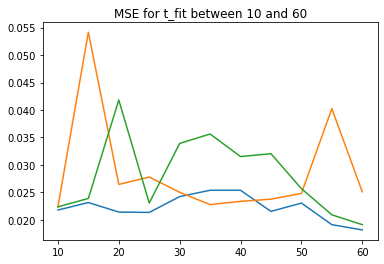

In [77]:
# plt.plot(fit_lengths, pd.DataFrame(fit_results))
# plt.title("MSE for t_fit between 10 and 60")
# plt.show()